<a href="https://colab.research.google.com/github/MikeXL/brain/blob/master/wine_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip -q install torch_nightly -f \
        https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html

In [0]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from sklearn import datasets
import sklearn

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [0]:
wine = datasets.load_wine()
wine.data = sklearn.preprocessing.scale(wine.data)   ## scale prior training

x = torch.from_numpy(wine.data).float()              ## features
y = torch.from_numpy(wine.target).long()             ## target

In [0]:
                                                     ## valilla neural net with 
model = nn.Sequential(
  nn.Linear(13,6),
  nn.ReLU(),
  nn.Linear(6,3),
  nn.Softmax(1)
)

In [0]:
def init_weight(m):
    #print m.__class__.__name__
    if isinstance(m, nn.Linear):
        #nn.init.normal_(m.weight.data, 1.0, 0.02)
        #nn.init.constant_(m.bias.data, 0)
        m.reset_parameters()
        #print m.weight.data, m.bias.data


In [0]:
def score(model, x, y):
  model.eval()
  out=model(x)
  _, pred = torch.max(out, 1)

  print "Misclassified %s/%s" % \
         ((y.size(0) - (pred.data==y.data).sum(0)), y.size(0))


In [0]:
EPOCH = 100
lr = .1
lf = nn.CrossEntropyLoss()

In [0]:
# use LBFGS
optim   = torch.optim.LBFGS(model.parameters(), lr=lr)
# for tracing training and validation losses
tlosses, vlosses = [], []
# initilize network weight
model.apply(init_weight)
# begin training
for _ in range(EPOCH):
    if _%4 < 3:
      #print _
      def closure():
        optim.zero_grad()
        yhat = model(x)
        loss = lf(yhat, y)
        tlosses.append(loss.item())
        loss.backward()
        return loss
      optim.step(closure)
    else:
      #print "validation %s" %_
      with torch.no_grad():
        pred = model(x)
        l = lf(pred, y)
        vlosses.append(l.item())


In [0]:
for _ in model.parameters():
  print _

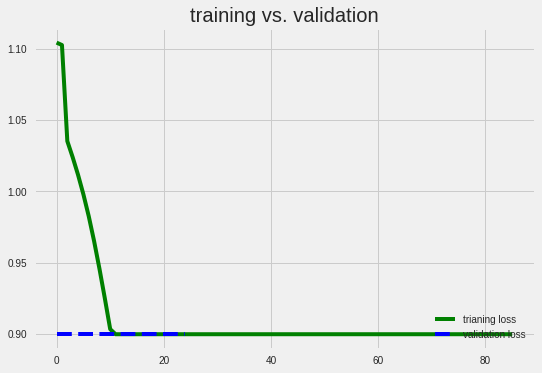

In [172]:
plt.plot(tlosses, 'g-', label='trianing loss')
plt.plot(vlosses, 'b--', label='validation loss')
plt.legend(loc="lower right")
plt.title("training vs. validation")

In [0]:

# train Adam, SGD, RMSprop
optim = torch.optim.Adam(model.parameters(), lr=lr)
# optim = torch.optim.SGD(model.parameters(), lr=lr)
# optim = torch.optim.RMSprop(model.parameters(), lr=lr)
# trace training and validation losses
tlosses, vlosses = [], []
# initialize network weight
model.apply(init_weight)
for _ in range(EPOCH):
    if _%4 < 3:
      optim.zero_grad()
      yhat = model(x)
      loss = lf(yhat, y)
      tlosses.append(loss.item())
      loss.backward()
      optim.step()
    else:
      # validation
      with torch.no_grad():
        pred = model(x)
        l = lf(pred, y)
        vlosses.append(l.item())


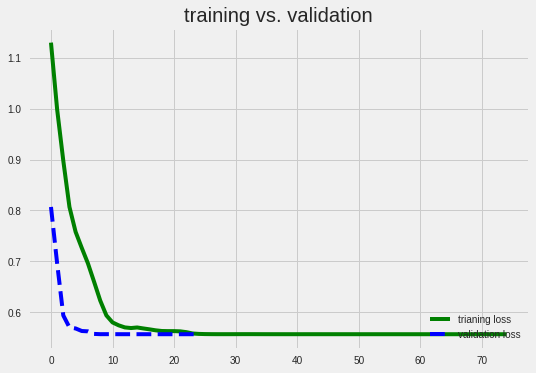

In [174]:
plt.plot(tlosses, 'g-', label='trianing loss')
plt.plot(vlosses, 'b--', label='validation loss')
plt.legend(loc="lower right")
plt.title("training vs. validation")